# Setup

In [6]:
import importlib
import os

import joblib
import pandas as pd

import tlp

url = 'https://snap.stanford.edu/data/soc-redditHyperlinks-title.tsv'
dataset_id = '29'
adjusted_intervals = dict()

# Download and extract data

In [7]:
os.makedirs(dataset_id, exist_ok=True)
edgelist_location = f'{dataset_id}/edgelist.pkl'
download_location = os.path.join(dataset_id, 'soc-redditHyperlinks-title.tsv')
if not os.path.isfile(edgelist_location):
  if not os.path.isfile(download_location):
    tlp.download_from_url(url, download_location, verbose=True)
    
  df = pd.read_csv(download_location, sep='\t', index_col=False, 
                   parse_dates=['TIMESTAMP'])
  df = df[df['LINK_SENTIMENT'] == 1]
  df = df.rename(
  columns={'SOURCE_SUBREDDIT': 'source', 'TARGET_SUBREDDIT': 'target', 
         'TIMESTAMP': 'datetime'})
  df[['source', 'target', 'datetime']].to_pickle(edgelist_location)

soc-redditHyperlinks-title.tsv:   0%|          | 0.00/369M [00:00<?, ?B/s]

# Splitting

In [8]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 1.03 s, sys: 15.5 ms, total: 1.05 s
Wall time: 1.1 s


# Instances

In [9]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 3min 17s, sys: 4.92 s, total: 3min 21s
Wall time: 3min 21s


# Targets

In [10]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/24386801 [00:00<?, ?it/s]

CPU times: user 48.1 s, sys: 1.65 s, total: 49.8 s
Wall time: 49.6 s


# Sampling

In [11]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 776 ms, sys: 330 ms, total: 1.11 s
Wall time: 1.13 s


# Features

## AA (time agnostic)

In [12]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 2.98 s, sys: 31.4 ms, total: 3.01 s
Wall time: 3.02 s


## AA (time aware)

In [13]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 1min 48s, sys: 1.37 s, total: 1min 49s
Wall time: 1min 48s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

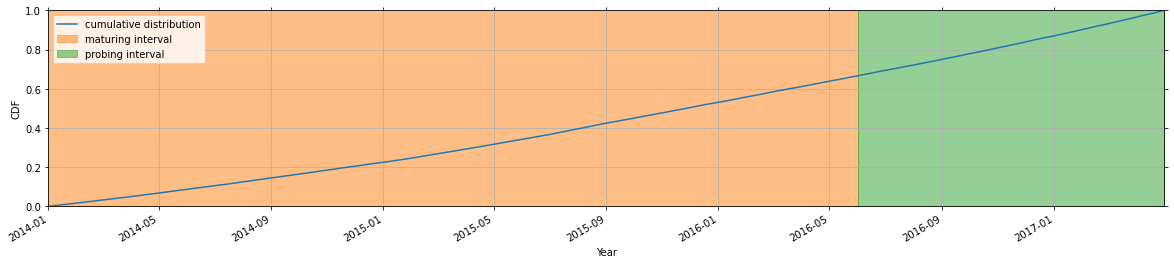

In [14]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'], **adjusted_intervals)

## Metric: Class imbalance

In [15]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,24371192,0.99936
True,15609,0.00064


## Figure: Datetime strategies

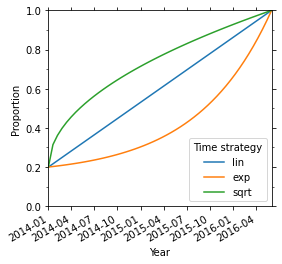

In [16]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

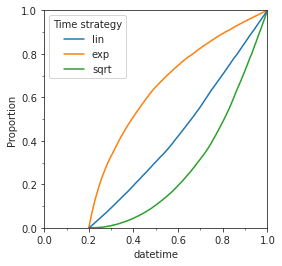

In [17]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

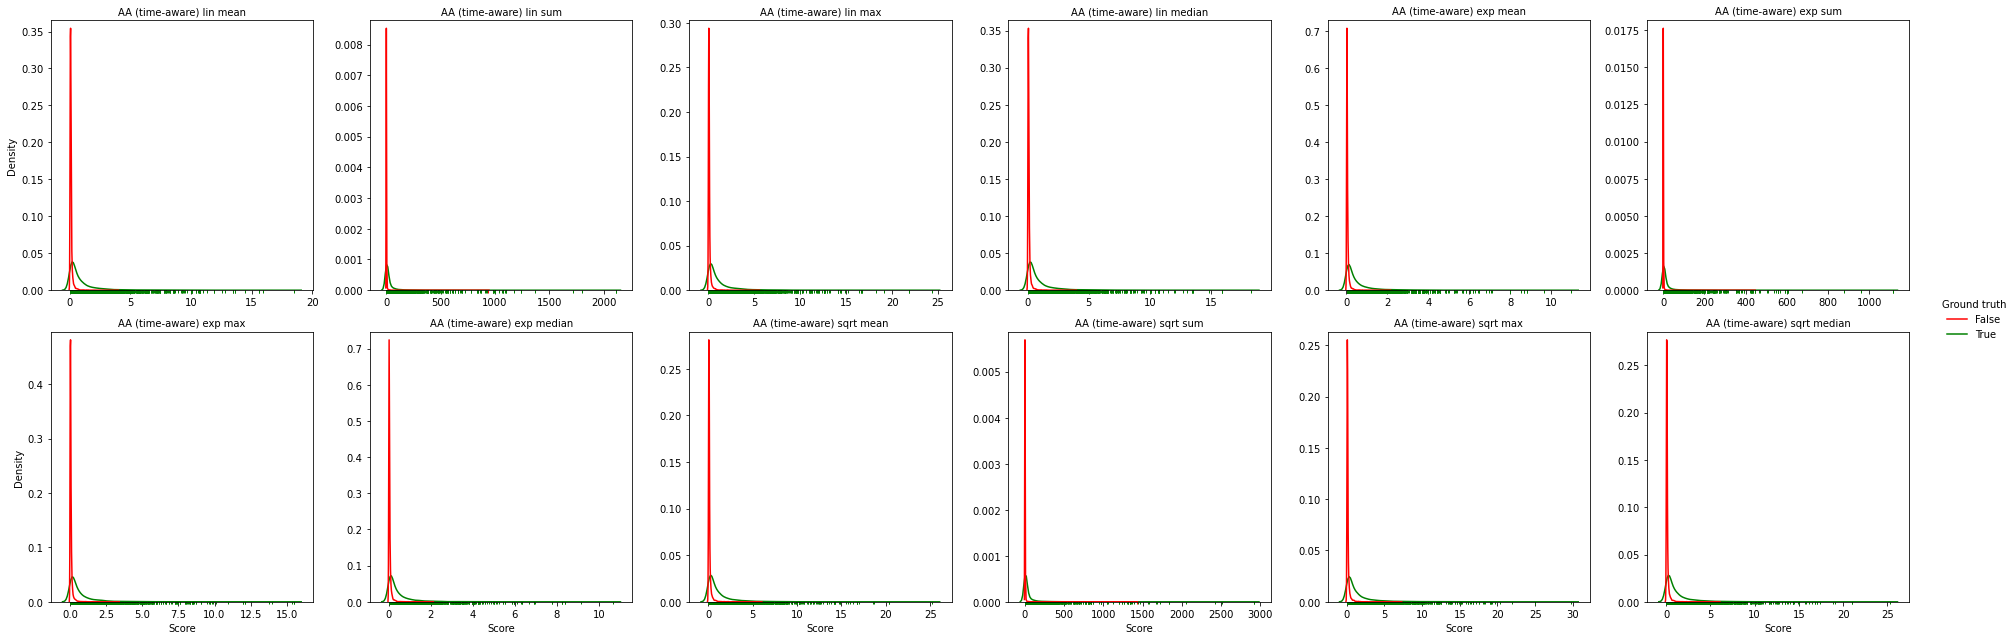

In [18]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

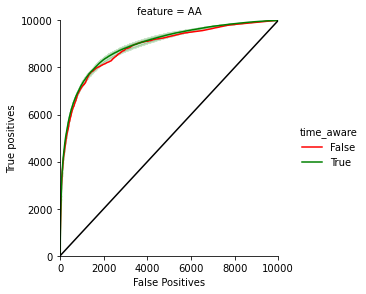

In [19]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [20]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.885414
         True        mean                  lin              0.888374
                     sum                   lin              0.897435
                     max                   lin              0.900053
                     median                lin              0.888007
                     mean                  exp              0.887810
                     sum                   exp              0.899419
                     max                   exp              0.901614
                     median                exp              0.883326
                     mean                  sqrt             0.890153
                     sum                   sqrt             0.895350
                     max                   sqrt             0.899001
                     median                sqrt             0.891048
Name: auc, dtype: float64